# 계산기 에이전트 만들기 - Functional API

* **Functional API**
  에이전트를 **하나의 함수(function)** 로 정의하고 싶을 때 사용합니다.
  (즉, 단일 입력 → 단일 출력 구조를 선호하는 경우)

In [3]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
from langchain.chat_models import init_chat_model

# model = init_chat_model("gpt-5-nano", model_provider="openai")
model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

In [5]:
from langchain_core.tools import tool

# 도구 정의 (LLM이 사용할 수 있는 계산 기능)
@tool
def multiply(a: int, b: int) -> int:
    """`a`와 `b`를 곱합니다.

    매개변수(Args):
        a: 첫 번째 정수
        b: 두 번째 정수
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """`a`와 `b`를 더합니다.

    매개변수(Args):
        a: 첫 번째 정수
        b: 두 번째 정수
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """`a`를 `b`로 나눕니다.

    매개변수(Args):
        a: 첫 번째 정수
        b: 두 번째 정수
    """
    return a / b

# 사용할 도구(연산 함수)들을 리스트로 정의
tools = [add, multiply, divide]

# 도구 이름(name)을 키로 하여 빠르게 접근할 수 있는 딕셔너리 형태로 변환
tools_by_name = {tool.name: tool for tool in tools}

# 모델에 도구 목록을 바인딩(bind)
model_with_tools = model.bind_tools(tools)
model_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-2.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x000001D33ED75160>, default_metadata=(), model_kwargs={}), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': '`a`와 `b`를 더합니다.\n\n    매개변수(Args):\n        a: 첫 번째 정수\n        b: 두 번째 정수', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': '`a`와 `b`를 곱합니다.\n\n    매개변수(Args):\n        a: 첫 번째 정수\n        b: 두 번째 정수', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': '`a`를 `b`로 나눕니다.\n\n    매개변수(Args):\n        a: 첫 번째 정수\n        b: 두 번째 정수', '

### **모델 노드(Model Node) 정의**

모델 노드는 **LLM(대형 언어 모델)** 을 호출하고, **도구(tool)** 를 호출해야 할지 여부를 결정하는 역할을 합니다.  
즉, 이 노드는 모델이 입력된 메시지를 바탕으로
“직접 대답할지” 혹은 “도구(예: 계산기, 검색기 등)를 사용해야 할지” 판단하는 **의사결정 지점**입니다.

In [10]:
from langchain.messages import SystemMessage, HumanMessage, ToolCall
from langchain_core.messages import BaseMessage
from langgraph.func import entrypoint, task

@task
def call_llm(messages: list[BaseMessage]):
    return model_with_tools.invoke(
        [
            # 시스템 메시지: LLM에게 기본 역할을 부여하는 지시문
            SystemMessage(
                content="당신은 주어진 입력값에 대해 산술 연산을 수행하는 친절한 도우미입니다."
            )
        ]
        # 사용자 또는 이전 LLM 응답 등의 대화 메시지를 이어붙여서 전달
        + messages
    )

### **도구 노드 정의 (Define tool node)**

도구 노드는 **등록된 도구(tools)** 를 실제로 호출하고, 그 **결과(result)** 를 반환하는 역할을 합니다.  

In [11]:
@task
def call_tool(tool_call: ToolCall):
    """도구 호출을 수행합니다."""
    tool = tools_by_name[tool_call["name"]]  # 호출된 도구 이름에 해당하는 실제 도구 객체를 가져옴
    return tool.invoke(tool_call)            # 해당 도구를 실행하고 결과를 반환

### **에이전트 정의**
`@entrypoint`는 **LangGraph Functional API**에서 에이전트의 **시작점(진입 지점, entry point)** 을 정의하는 데 사용됩니다.

이 함수 안에서는 LLM 호출, 도구 실행, 조건 분기 등 에이전트의 전체 동작 흐름을 **일반적인 파이썬 제어 구조(루프, 조건문 등)** 로 구성할 수 있습니다.

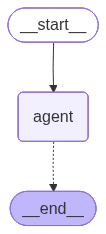

In [12]:
from langgraph.graph import add_messages

@entrypoint()
def agent(messages: list[BaseMessage]):
    model_response = call_llm(messages).result()

    # ReAct 루프 시작
    # LLM이 'tool_call'을 반환하는 동안 계속 반복 실행
    while True:
        # LLM 응답에 아무 도구 호출이 없다면 종료
        if not model_response.tool_calls:
            break

        # model_response.tool_calls 리스트를 순회하며 실제 도구 비동기 실행
        tool_result_futures = [
            call_tool(tool_call)       # 특정 tool_call 비동기 실행 
            for tool_call in model_response.tool_calls
        ]

        # 모든 도구 실행 결과를 .result()로 획득
        tool_results = [fut.result() for fut in tool_result_futures]

        # 기존 메시지 + LLM 응답 + 도구 결과를 모두 대화 히스토리에 추가
        # add_messages 는 LangGraph 의 메시지 누적 도우미
        messages = add_messages(messages, [model_response, *tool_results])

        # 새 메시지 히스토리를 기반으로 LLM을 다시 호출하여 다음 step으로 진행
        model_response = call_llm(messages).result()

    # 도구 호출이 끝난 마지막 LLM 응답을 히스토리에 추가
    messages = add_messages(messages, model_response)

    # 모든 메시지를 반환 (최종 대화 기록)
    return messages

# entrypoint 로 만들어진 에이전트 핸들
agent

In [17]:
# 에이전트 실행
messages = [HumanMessage(content="3과 4를 더해줘.")]
for chunk in agent.stream(messages, stream_mode="updates"):   # {"노드이름": 노드의 출력값}
# for chunk in agent.stream(messages, stream_mode="values"):   # 엔트리포인트(agent)의 최종 state 값만 스트리밍
    print(chunk)
    print("\n")

[HumanMessage(content='3과 4를 더해줘.', additional_kwargs={}, response_metadata={}, id='9faebd3a-629f-4c35-9a0a-f4532e2ee417'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 3, "b": 4}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--6625f67e-68a9-440b-99f1-0b90c18e2e54-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': '2e3bcf13-526b-45a6-b035-5abac62a3c38', 'type': 'tool_call'}], usage_metadata={'input_tokens': 264, 'output_tokens': 81, 'total_tokens': 345, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 63}}), ToolMessage(content='7', name='add', id='b9179b53-df6f-43c8-8420-b8024efd118b', tool_call_id='2e3bcf13-526b-45a6-b035-5abac62a3c38'), AIMessage(content='3과 4를 더하면 7입니다.', additional_kwargs={}, response_